<a href="https://colab.research.google.com/github/Ras-hi/Predicting-flight-Delays/blob/main/Cognizant_Flight_delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the libraries**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


# **Load the Dataset**

In [17]:
df = pd.read_csv('/content/flight_new.csv')

# **EDA and Basic Information**

In [18]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100239 entries, 0 to 100238
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   FL_DATE       100239 non-null  object 
 1   AIRLINE       100239 non-null  object 
 2   ORIGIN        100239 non-null  object 
 3   DEST          100239 non-null  object 
 4   CRS_DEP_TIME  100239 non-null  int64  
 5   ARR_DELAY     97864 non-null   float64
 6   CANCELLED     100239 non-null  float64
 7   DIVERTED      100239 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 6.1+ MB


,CRS_DEP_TIME,ARR_DELAY,CANCELLED,DIVERTED
count,100239.000000,97864.000000,100239.000000,100239.000000
mean,1309.097327,4.545441,0.021449,0.002245
std,505.404625,49.237807,0.144875,0.047325
min,2.000000,-82.000000,0.000000,0.000000
25%,900.000000,-15.000000,0.000000,0.000000
50%,1310.000000,-6.000000,0.000000,0.000000
75%,1725.000000,8.000000,0.000000,0.000000
max,2359.000000,1572.000000,1.000000,1.000000


# **Handle Missing Values**

In [19]:
df['ARR_DELAY'].fillna(df['ARR_DELAY'].mean(), inplace=True)

# **Boxplots for Outliers**
# Boxplot for ARR_DELAY

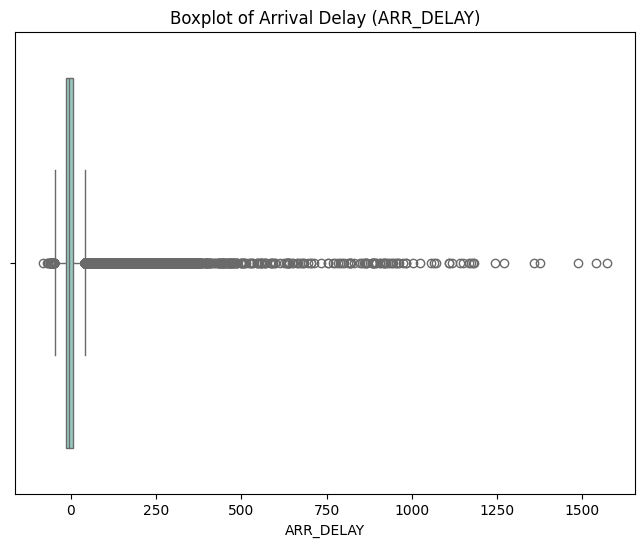

In [20]:
plt.figure(figsize=(8, 6))
sb.boxplot(x='ARR_DELAY', data=df, palette="Set3")
plt.title('Boxplot of Arrival Delay (ARR_DELAY)')
plt.show()


### **Key Observations from the Boxplot**:
 1. **Median (Central Line of the Box)**: * The line inside the box represents the **median** (or 50th percentile) of the data, which is around 0. This indicates that most flights have **no significant arrival delays**.
 2. **Interquartile Range (IQR)**: * The box itself shows the **interquartile range (IQR)**, which spans from the **25th percentile** to the **75th percentile**. The upper and lower boundaries of the box represent these percentiles. * Given that the box is narrow and positioned near 0, most flights have **little to no delays**.
 3. **Whiskers (Lines Extending from the Box)**: * The whiskers show the range of most of the data, typically extending 1.5 times the IQR from the quartiles. * The whiskers extend slightly above zero, but not much, indicating that most of the flights are either on time or have minimal delays.
 4. **Outliers**: * **Dots beyond the whiskers** represent **outliers**, which are extreme delay values. In this case, there are a **significant number of outliers**, with some flights having arrival delays well over 500 minutes (about 8+ hours). * These outliers indicate a small percentage of flights experiencing **extreme delays**.
 ### **Overall Interpretation**:
 * **Most flights** in your dataset seem to arrive **on time** or have minimal delays, as indicated by the concentration of values around 0.
 * However, there are **a large number of outliers** (extreme delay cases), which suggests that while the majority of flights have no or little delay, **some flights are severely delayed**, contributing to a wide range of delay times beyond 200 minutes and even exceeding 1000 minutes in rare cases.





# **Correlation Matrix**

In [37]:
numeric_df = df.select_dtypes(include=['number'])

# Correlation matrix

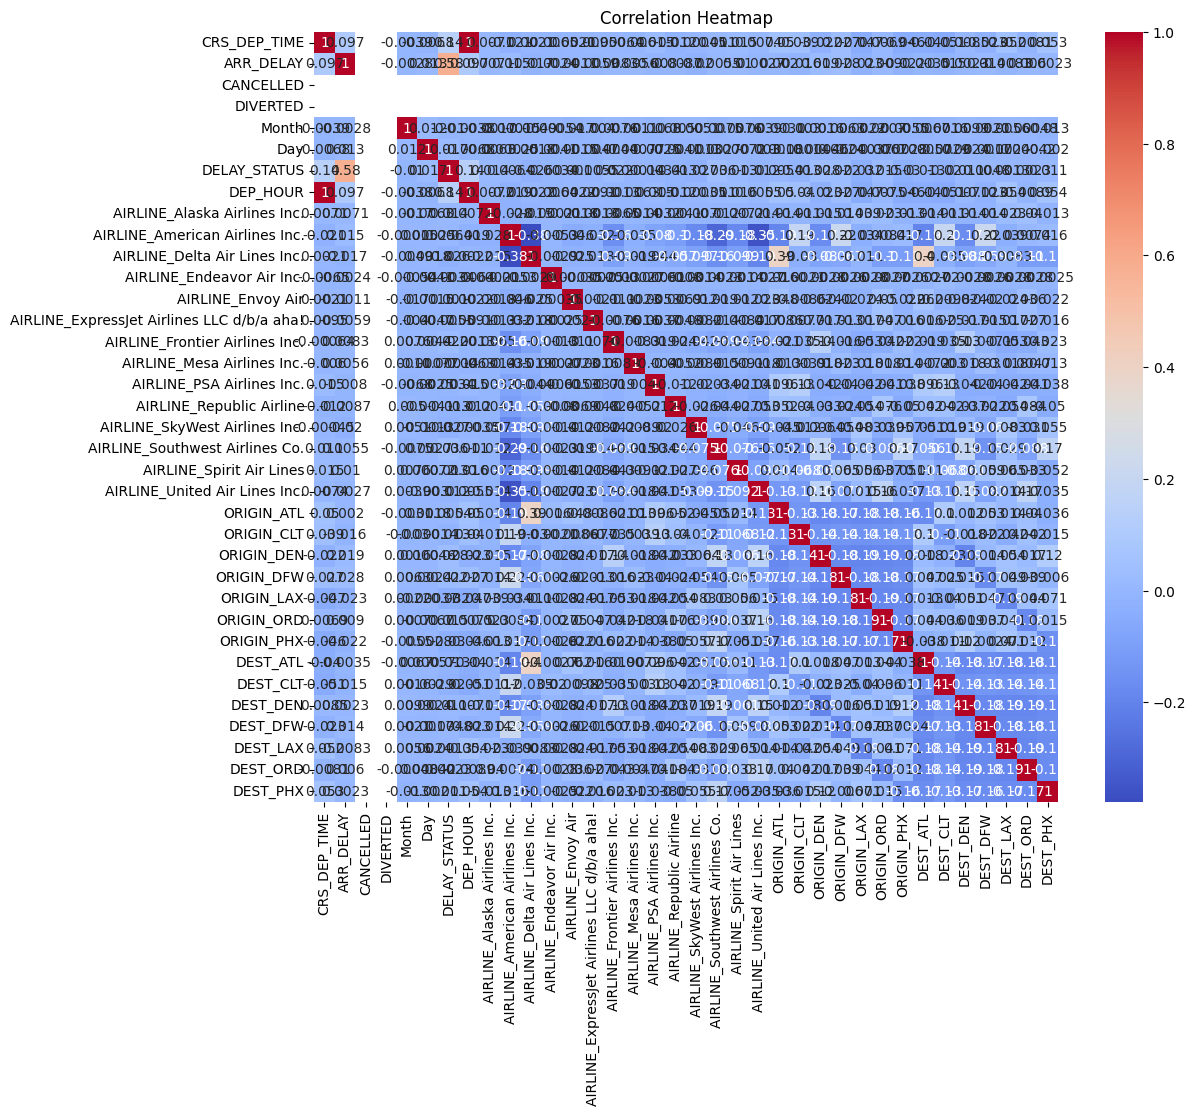

In [38]:
plt.figure(figsize=(12, 10))
sb.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# **Handling Cancellations and Diversions**

In [21]:
df = df[(df['DIVERTED'] == False) & (df['CANCELLED'] == False)]

# **Feature Engineering: Convert Date to Day and Month**

In [22]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')
df['Month'] = df['FL_DATE'].dt.month
df['Day'] = df['FL_DATE'].dt.day
df = df.drop(columns=['FL_DATE'])

# **Check Variance**

In [39]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])
variance = numerical_df.var()
print("Feature Variances:")
print(variance)


Feature Variances:
CRS_DEP_TIME                                  255077.319901
ARR_DELAY                                       2424.361607
CANCELLED                                          0.000000
DIVERTED                                           0.000000
DELAY_STATUS                                       0.172207
DEP_HOUR                                          25.220297
AIRLINE_Alaska Airlines Inc.                       0.001102
AIRLINE_American Airlines Inc.                     0.241291
AIRLINE_Delta Air Lines Inc.                       0.142762
AIRLINE_Endeavor Air Inc.                          0.000041
AIRLINE_Envoy Air                                  0.003026
AIRLINE_ExpressJet Airlines LLC d/b/a aha!         0.001510
AIRLINE_Frontier Airlines Inc.                     0.035745
AIRLINE_Mesa Airlines Inc.                         0.001765
AIRLINE_PSA Airlines Inc.                          0.009072
AIRLINE_Republic Airline                           0.015013
AIRLINE_SkyWest Airli

# **Convert ARR_DELAY to Binary (0 = No Delay, 1 = Delay > 10 minutes)**
# Create a new column DELAY_STATUS for binary delay classification

In [23]:
df['DELAY_STATUS'] = df['ARR_DELAY'].apply(lambda x: 1 if x > 10 else 0)


# **EDA: Visualize Delay Proportions**


# Proportion of Delays

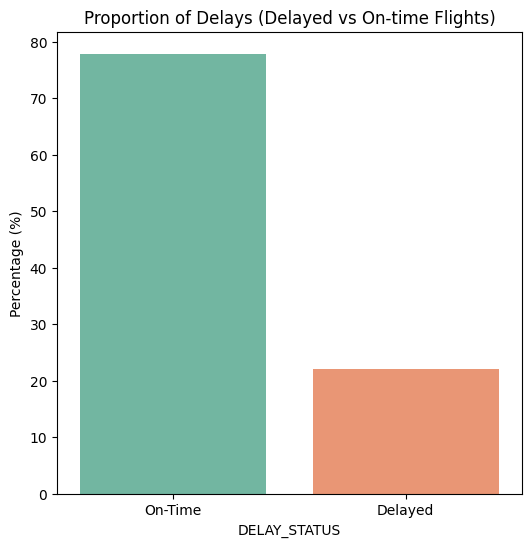

In [24]:
delay_counts = df['DELAY_STATUS'].value_counts(normalize=True) * 100
plt.figure(figsize=(6, 6))
sb.barplot(x=delay_counts.index, y=delay_counts.values, palette="Set2")
plt.title('Proportion of Delays (Delayed vs On-time Flights)')
plt.xticks([0, 1], ['On-Time', 'Delayed'])
plt.ylabel('Percentage (%)')
plt.show()

# **More Feature Engineering: Extract Hour from CRS_DEP_TIME**

In [25]:
df['DEP_HOUR'] = df['CRS_DEP_TIME'] // 100

# **Encoding Categorical Features**

In [26]:
df = pd.get_dummies(df, columns=['AIRLINE', 'ORIGIN', 'DEST'])

# **Convert Boolean Columns to Binary**

In [27]:
boolean_cols = df.select_dtypes(include='bool').columns
df[boolean_cols] = df[boolean_cols].astype(int)

# **Data Splitting**

In [28]:
X = df.drop(columns=['ARR_DELAY', 'DELAY_STATUS'])  # Dropping ARR_DELAY and using DELAY_STATUS
y = df['DELAY_STATUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model Training: Random Forest Classifier**

In [29]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# **Model Evaluation: Random Forest**

In [30]:
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {accuracy_rf}')
print(f'Random Forest Precision: {precision_rf}')
print(f'Random Forest Recall: {recall_rf}')
print('Random Forest Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7489909569304655
Random Forest Precision: 0.3570731707317073
Random Forest Recall: 0.16917032586087358
Random Forest Confusion Matrix:
[[13928  1318]
 [ 3595   732]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85     15246
           1       0.36      0.17      0.23      4327

    accuracy                           0.75     19573
   macro avg       0.58      0.54      0.54     19573
weighted avg       0.70      0.75      0.71     19573



# **Model Training: XGBoost Classifier**

In [31]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# **Model Evaluation: XGBoost**

In [32]:
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)

print(f'XGBoost Accuracy: {accuracy_xgb}')
print(f'XGBoost Precision: {precision_xgb}')
print(f'XGBoost Recall: {recall_xgb}')
print('XGBoost Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xgb))
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7774996168190875
XGBoost Precision: 0.4752650176678445
XGBoost Recall: 0.06216778368384562
XGBoost Confusion Matrix:
[[14949   297]
 [ 4058   269]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87     15246
           1       0.48      0.06      0.11      4327

    accuracy                           0.78     19573
   macro avg       0.63      0.52      0.49     19573
weighted avg       0.72      0.78      0.70     19573



# **Model Training: Decision Tree Classifier**

In [33]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# **Model Evaluation: Decision Tree**

In [34]:
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

print(f'Decision Tree Accuracy: {accuracy_dt}')
print(f'Decision Tree Precision: {precision_dt}')
print(f'Decision Tree Recall: {recall_dt}')
print('Decision Tree Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_dt))
print('Decision Tree Classification Report:')
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.6765953098656312
Decision Tree Precision: 0.2826134143694378
Decision Tree Recall: 0.3009013173099145
Decision Tree Confusion Matrix:
[[11941  3305]
 [ 3025  1302]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     15246
           1       0.28      0.30      0.29      4327

    accuracy                           0.68     19573
   macro avg       0.54      0.54      0.54     19573
weighted avg       0.68      0.68      0.68     19573



# **Model Training: Support Vector Machine (SVM)**

In [35]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

# **Model Evaluation: SVM**

In [36]:
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)

print(f'SVM Accuracy: {accuracy_svm}')
print(f'SVM Precision: {precision_svm}')
print(f'SVM Recall: {recall_svm}')
print('SVM Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7789301588923517
SVM Precision: 0.0
SVM Recall: 0.0
SVM Confusion Matrix:
[[15246     0]
 [ 4327     0]]
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     15246
           1       0.00      0.00      0.00      4327

    accuracy                           0.78     19573
   macro avg       0.39      0.50      0.44     19573
weighted avg       0.61      0.78      0.68     19573



#Overfitting/Underfitting test

In [41]:
# **Model Training and Overfitting Check**

# **Random Forest Classifier**
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on both train and test sets
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Accuracy, Precision, Recall for Train and Test
print("Random Forest Performance")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Train Precision:", precision_score(y_train, y_train_pred_rf))
print("Test Precision:", precision_score(y_test, y_test_pred_rf))
print("Train Recall:", recall_score(y_train, y_train_pred_rf))
print("Test Recall:", recall_score(y_test, y_test_pred_rf))
print("\n")

# **XGBoost Classifier**
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions on both train and test sets
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Accuracy, Precision, Recall for Train and Test
print("XGBoost Performance")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_xgb))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("Train Precision:", precision_score(y_train, y_train_pred_xgb))
print("Test Precision:", precision_score(y_test, y_test_pred_xgb))
print("Train Recall:", recall_score(y_train, y_train_pred_xgb))
print("Test Recall:", recall_score(y_test, y_test_pred_xgb))
print("\n")

# **Decision Tree Classifier**
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions on both train and test sets
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# Accuracy, Precision, Recall for Train and Test
print("Decision Tree Performance")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_dt))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_dt))
print("Train Precision:", precision_score(y_train, y_train_pred_dt))
print("Test Precision:", precision_score(y_test, y_test_pred_dt))
print("Train Recall:", recall_score(y_train, y_train_pred_dt))
print("Test Recall:", recall_score(y_test, y_test_pred_dt))
print("\n")

# **Support Vector Machine (SVM)**
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predictions on both train and test sets
y_train_pred_svm = svm_model.predict(X_train)
y_test_pred_svm = svm_model.predict(X_test)

# Accuracy, Precision, Recall for Train and Test
print("SVM Performance")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_svm))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("Train Precision:", precision_score(y_train, y_train_pred_svm))
print("Test Precision:", precision_score(y_test, y_test_pred_svm))
print("Train Recall:", recall_score(y_train, y_train_pred_svm))
print("Test Recall:", recall_score(y_test, y_test_pred_svm))
print("\n")


Random Forest Performance
Train Accuracy: 0.9976625665785339
Test Accuracy: 0.7489909569304655
Train Precision: 0.9978488372093023
Test Precision: 0.3570731707317073
Train Recall: 0.991565081749379
Test Recall: 0.16917032586087358


XGBoost Performance
Train Accuracy: 0.7945102246746114
Test Accuracy: 0.7774996168190875
Train Precision: 0.7406385494678754
Test Precision: 0.4752650176678445
Train Recall: 0.10855624241723959
Test Recall: 0.06216778368384562


Decision Tree Performance
Train Accuracy: 0.9977264308796668
Test Accuracy: 0.6765953098656312
Train Precision: 0.9998832798365918
Test Precision: 0.2826134143694378
Train Recall: 0.9898318793691143
Test Recall: 0.3009013173099145


SVM Performance
Train Accuracy: 0.7789145623379443
Test Accuracy: 0.7789301588923517
Train Precision: 0.0
Test Precision: 0.0
Train Recall: 0.0
Test Recall: 0.0




**Interpretation**:
* **Overfitting**: Both the **Random Forest** and **Decision Tree** classifiers show **overfitting** behavior.
 * The **train accuracy, precision, and recall** are extremely high, almost perfect, indicating that the models are learning the training data too well, potentially even capturing noise in the data.
 * However, when tested on unseen data (the test set), the **test accuracy, precision, and recall** drop significantly, especially precision and recall, indicating that the models do not generalize well on new data.
 * The large gap between training and testing performance is a strong indication of **overfitting**.





**Interpretation**:
* **Underfitting**: The **XGBoost** model is likely **underfitting**.
 * Both the **train and test accuracy** are relatively lower compared to Random Forest and Decision Tree.
 * The **train precision and recall** are particularly low, indicating that the model is not capturing enough relevant patterns from the training data.
 * While the **test accuracy is slightly better** than the Decision Tree, the low performance on training metrics indicates that the model may not have enough complexity to capture the relationship in the data, leading to **underfitting**.





##1\. Random Forest Tuning

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Tuning Random Forest to reduce overfitting
rf_model = RandomForestClassifier(
    n_estimators=100,  # number of trees
    max_depth=10,  # limit depth of trees
    min_samples_split=10,  # minimum samples required to split a node
    min_samples_leaf=5,  # minimum samples in each leaf node
    max_features='sqrt',  # number of features to consider at each split
    random_state=42
)

# Training
rf_model.fit(X_train, y_train)

# Predicting
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluating
print("Random Forest Performance After Tuning")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_rf)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_rf)}")
print(f"Train Precision: {precision_score(y_train, y_train_pred_rf)}")
print(f"Test Precision: {precision_score(y_test, y_test_pred_rf)}")
print(f"Train Recall: {recall_score(y_train, y_train_pred_rf)}")
print(f"Test Recall: {recall_score(y_test, y_test_pred_rf)}")


Random Forest Performance After Tuning
Train Accuracy: 0.7795787510697271
Test Accuracy: 0.7792877944106678
Train Precision: 0.8095238095238095
Test Precision: 0.7058823529411765
Train Recall: 0.003928592061933098
Test Recall: 0.0027732840305061245


##2\. Decision Tree Tuning

In [43]:
from sklearn.tree import DecisionTreeClassifier

# Tuning Decision Tree to reduce overfitting
dt_model = DecisionTreeClassifier(
    max_depth=10,  # limit tree depth
    min_samples_split=10,  # minimum samples required to split a node
    min_samples_leaf=5,  # minimum samples required in each leaf node
    random_state=42
)

# Training
dt_model.fit(X_train, y_train)

# Predicting
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# Evaluating
print("Decision Tree Performance After Tuning")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_dt)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_dt)}")
print(f"Train Precision: {precision_score(y_train, y_train_pred_dt)}")
print(f"Test Precision: {precision_score(y_test, y_test_pred_dt)}")
print(f"Train Recall: {recall_score(y_train, y_train_pred_dt)}")
print(f"Test Recall: {recall_score(y_test, y_test_pred_dt)}")


Decision Tree Performance After Tuning
Train Accuracy: 0.7856075410966777
Test Accuracy: 0.7715219945843764
Train Precision: 0.6232361241768579
Test Precision: 0.36936936936936937
Train Recall: 0.07654977179501993
Test Recall: 0.04737693552114629


##3\. XGBoost Tuning

In [44]:
import xgboost as xgb

# Tuning XGBoost to address underfitting
xgb_model = xgb.XGBClassifier(
    n_estimators=200,  # increasing the number of trees
    max_depth=6,  # allowing slightly deeper trees
    learning_rate=0.1,  # lowering the learning rate
    subsample=0.8,  # subsampling to prevent overfitting
    colsample_bytree=0.8,  # using fewer features at each split
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Training
xgb_model.fit(X_train, y_train)

# Predicting
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluating
print("XGBoost Performance After Tuning")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_xgb)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_xgb)}")
print(f"Train Precision: {precision_score(y_train, y_train_pred_xgb)}")
print(f"Test Precision: {precision_score(y_test, y_test_pred_xgb)}")
print(f"Train Recall: {recall_score(y_train, y_train_pred_xgb)}")
print(f"Test Recall: {recall_score(y_test, y_test_pred_xgb)}")


XGBoost Performance After Tuning
Train Accuracy: 0.7889668033362711
Test Accuracy: 0.7807694272722628
Train Precision: 0.7237066515065378
Test Precision: 0.5461538461538461
Train Recall: 0.07354555433589462
Test Recall: 0.04922579154148371
